# Q-learning

In [75]:
import random
import numpy as np
import matplotlib.pyplot as plt

from tic_env import TictactoeEnv, OptimalPlayer

In [63]:
st2int = lambda st: int(((st.flatten() + 1) * (3**np.arange(9))).sum())

# https://xkcd.com/832/
class Player:
    def __init__(self, learning_rate, discount_factor, exp_rate):
        self.states = []
        self.states_value = {}  # state -> value
        self.lr = learning_rate
        self.decay_gamma = discount_factor
        self.exp_rate = exp_rate
        self.exp = 0
        self.env = TictactoeEnv()
                
    def act(self, grid, symbol, eps):
        assert symbol in ['X', 'O']
        
        if np.random.uniform(0, 1) <= eps:
            action = self.random_move(grid)
        else:
            positions = self.available_positions(grid)
            value_max = -999
            num_symb = 1 if symbol == 'X' else -1
            for p in positions:
                next_board = grid.copy()
                next_board[p] = num_symb
                state_key = st2int(next_board)
                value = 0 if self.states_value.get(state_key) is None else self.states_value[state_key]
                if value >= value_max:
                    value_max = value
                    action = p
        return action
    
    def random_move(self, grid):
        """ Chose a random move from the available options. """
        return random.choice(self.available_positions(grid))
         
    def available_positions(self, grid): #nommé empty dans env
        '''return all empty positions'''
        return [(i // 3, i % 3) for i in range(9) if not grid[(i // 3, i % 3)]]
    
    def update_qtable(self, states, reward):
        for state in reversed(self.states):
            if self.states_value.get(state) is None:
                self.states_value[state] = 0
            self.states_value[state] += self.lr*(self.decay_gamma*reward - self.states_value[state])
            reward = self.states_value[state]
            
    def add_state(self, state):
        self.states.append(st2int(state))
            
    def train(self, N, epsilon=0):
        Turns = np.array(['X','O'])
        total_reward = 0
        for i in range(1, N+1):
            self.exp += 1
            self.env.reset()
            grid, _, __ = self.env.observe()
            Turns = Turns[::-1]
            player_opt = OptimalPlayer(epsilon, player=Turns[0])
                
            end = 0  # to run first iteration
            while not end:
                if self.env.current_player == player_opt.player:
                    move = player_opt.act(grid)
                else:
                    move = self.act(grid, Turns[1], self.exp_rate)

                grid, end, winner = self.env.step(move, print_grid=False)
                self.add_state(self.env.grid.reshape(9))
            
            reward = self.env.reward(Turns[1])
            total_reward += reward
            self.update_qtable(self.states, reward)
        return total_reward 
                    
    def test_policy(self, N_test, epsilon=0.):
        Turns = np.array(['X','O'])
        n_wins = 0
        n_loss = 0
        
        for i in range(N_test):
            self.env.reset()
            grid, _, __ = self.env.observe()
            Turns = Turns[::-1]
            player_opt = OptimalPlayer(epsilon, player=Turns[0])
                
            for j in range(9):
                if self.env.current_player == player_opt.player:
                    move = player_opt.act(grid)
                else:
                    move = self.act(grid, Turns[1], 0)

                grid, end, winner = self.env.step(move, print_grid=False)
            
                if end:
                    if winner == Turns[1]:
                        n_wins +=1
                    if winner == Turns[0]:
                        n_loss +=1
                    self.env.reset()
#                     print("Your win is ", winner == Turns[1])
                    break
                    
        return (n_wins-n_loss)/N_test

In [61]:
#TRAIN PARAMETERS
learning_rate = 0.05
discount_factor = 0.99
expl_level = 0.5
optimal_eps_train = 0.5

my_player = Player(learning_rate, discount_factor, expl_level)

In [58]:
#TEST
optimal_eps_test = 0
games_to_test = 500
M = my_player.test_policy(games_to_test, optimal_eps_test)
print(M)

-0.178


##  Learning from experts

**Question 1**. Plot average reward for every 250 games during training – i.e. after the 50th game, plot
the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to
100, etc. Does the agent learn to play Tic Tac Toe? \
*Expected answer*: A figure of average reward over time (caption length < 50 words). Specify your choice
of $\epsilon$.

In [81]:
learning_rate = 0.05
discount_factor = 0.99
my_exp_rate = 0.5
opponent_exp_rate = 0.5

my_player = Player(learning_rate, discount_factor, my_exp_rate)

In [97]:
avgs = []
opponent_exp_rate = 0.5
N = 1000
avg_every = 250
batch_sz = 50
for i in range(1, N // avg_every + 1):
    batch = [my_player.train(batch_sz, opponent_exp_rate) for _ in range(avg_every // batch_sz)]
    avgs.append(1.*sum(batch) / len(batch))
    print(f"Ep: {avg_every*i}, avg: {round(avgs[-1], 3)}, {batch}")

250 -0.48 [-0.36, -0.7, -0.44, -0.4, -0.5]
500 -0.5 [-0.42, -0.64, -0.38, -0.54, -0.52]
750 -0.388 [-0.28, -0.46, -0.46, -0.22, -0.52]
1000 -0.436 [-0.5, -0.56, -0.28, -0.46, -0.38]


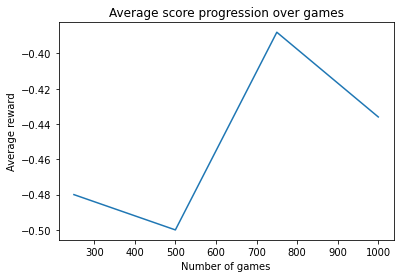

In [98]:
plt.plot((np.arange(len(avgs))+1)*avg_every, avgs)
plt.title('Average score progression over games')
plt.xlabel("Number of games")
plt.ylabel("Average reward")
plt.show()

The used exploration rate is $\epsilon=0.5$ because it should half of games explore and half of games play best strategy

###  Decreasing exploration

###  Good experts and bad experts

##  Learning by self-practice

#  Deep Q-Learning

In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


class DQLNN(nn.Module):
    """ DQLNN, expects input shape (3, 3, 2) """
    def __init__(self):
        super(DQLNN, self).__init__()

        self.fc1 = nn.Linear(3*3*2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 9)
        
    def forward(self, x):
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.flatten())))))
    
model_dql = DQLNN()

In [ ]:
# Player reinitializing

## Learning from experts

##      Learning by self-practice

# Comparing Q-Learning with Deep Q-Learning

I expect DQL working better than QL